In [1]:
import numpy as np
import nltk
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# nltk.download()
# from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

## Exploration

- Data berita
- Bahasa Inggris
- 20 kategori 

In [3]:
twenty_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

Memiliki 5 kunci utama :
- data : Isi berita
- filenames : mengandung lokasi file
- target_names = kategori berita
- target = label kategori berita
- DESCR - description berita

In [4]:
print(twenty_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
# kategori berita
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
# Extracting features from text files
count_vect = CountVectorizer(ngram_range=(2,2))
contoh_text = ['saya pergi ke kampus tadi pagi', 'saya makan roti', 'tadi pagi saya makan']
count_vect.fit_transform(contoh_text).toarray()

array([[1, 1, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 1]], dtype=int64)

In [7]:
# TF-IDF
tfidf_transformer = TfidfTransformer()
contoh_text = ['saya pergi ke kampus tadi pagi', 'saya makan roti', 'tadi pagi saya makan']
vector = count_vect.fit_transform(contoh_text).toarray()
tfidf_transformer.fit_transform(vector).toarray()

array([[0.46735098, 0.46735098, 0.        , 0.        , 0.46735098,
        0.        , 0.46735098, 0.35543247],
       [0.        , 0.        , 0.79596054, 0.        , 0.        ,
        0.60534851, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.68091856, 0.        ,
        0.51785612, 0.        , 0.51785612]])

In [8]:
data = twenty_train.data
target_names = twenty_train.target_names
target = twenty_train.target
dict = {'data': data, 'target': target} 
df = pd.DataFrame(dict)

In [9]:
df.data[2]

'From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swin

In [10]:
df.head()

,data,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


<AxesSubplot:title={'center':'Sebaran Kelompok'}, xlabel='target'>

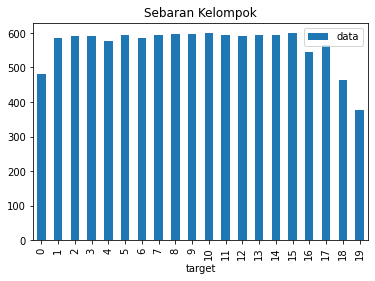

In [11]:
df.groupby(by='target').count().plot(kind='bar', title='Sebaran Kelompok')

In [12]:
import matplotlib.pyplot as plt
print("perbandingan max-min :",round(min(df.groupby(by='target').count().reset_index()['data'])/max(df.groupby(by='target').count().reset_index()['data']),2))
med = np.median(df.groupby(by='target').count().reset_index()['data'])
for i in range(20):
    if len(df[df.target==i]) < int(med):
        df = pd.concat([df,df[df.target==i].sample(int(med)-len(df[df.target==i]), replace=True)])

perbandingan max-min : 0.63


<AxesSubplot:title={'center':'Sebaran Kelompok'}, xlabel='target'>

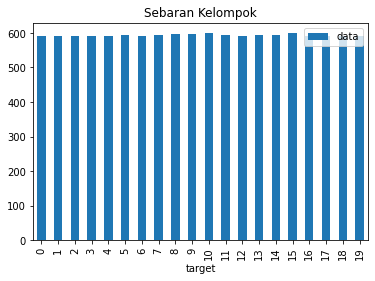

In [13]:
df.groupby(by='target').count().plot(kind='bar', title='Sebaran Kelompok')

## Modelling

In [14]:
twenty_train = df

In [15]:
#Feature Extraction

### Text to vector
count_vect = CountVectorizer()
twenty_train_vectors = count_vect.fit_transform(twenty_train.data)
### Vector to probability score
tfidf_transformer = TfidfTransformer()
twenty_train_tfidf = tfidf_transformer.fit_transform(twenty_train_vectors)

In [16]:
print("Dimensi vector: ", twenty_train_vectors.shape)
print("Dimensi TfIdf: ", twenty_train_tfidf.shape)

Dimensi vector:  (11864, 130107)
Dimensi TfIdf:  (11864, 130107)


In [17]:
# Model 1 : Multinomial Naive Bayes
mulnb = MultinomialNB().fit(twenty_train_tfidf, twenty_train.target)
mulnb_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
mulnb_clf = mulnb_clf.fit(twenty_train.data, twenty_train.target)
predicted = mulnb_clf.predict(twenty_test.data)
print('Akurasi :{}%'.format(round(np.mean(predicted == twenty_test.target),2)*100))

Akurasi :79.0%


In [18]:
print(classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.68      0.76      0.72       319
           comp.graphics       0.80      0.66      0.72       389
 comp.os.ms-windows.misc       0.82      0.64      0.72       394
comp.sys.ibm.pc.hardware       0.69      0.76      0.73       392
   comp.sys.mac.hardware       0.85      0.79      0.82       385
          comp.windows.x       0.91      0.75      0.82       395
            misc.forsale       0.92      0.70      0.80       390
               rec.autos       0.89      0.90      0.89       396
         rec.motorcycles       0.95      0.92      0.94       398
      rec.sport.baseball       0.94      0.89      0.91       397
        rec.sport.hockey       0.91      0.96      0.94       399
               sci.crypt       0.66      0.96      0.78       396
         sci.electronics       0.85      0.58      0.69       393
                 sci.med       0.94      0.70      0.80       396
         

In [19]:
# Model 2 : SVM Classifier
svm_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-2, max_iter=5, random_state=42))])

svm_clf = svm_clf.fit(twenty_train.data, twenty_train.target)
predicted_svm = svm_clf.predict(twenty_test.data)
print('Akurasi :{}%'.format(round(np.mean(predicted_svm == twenty_test.target),2)*100))

Akurasi :82.0%


In [20]:
print(classification_report(twenty_test.target, predicted_svm, target_names=twenty_test.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.70      0.73      0.72       319
           comp.graphics       0.80      0.71      0.75       389
 comp.os.ms-windows.misc       0.74      0.77      0.75       394
comp.sys.ibm.pc.hardware       0.74      0.67      0.71       392
   comp.sys.mac.hardware       0.82      0.81      0.82       385
          comp.windows.x       0.84      0.75      0.80       395
            misc.forsale       0.82      0.89      0.85       390
               rec.autos       0.91      0.89      0.90       396
         rec.motorcycles       0.92      0.96      0.94       398
      rec.sport.baseball       0.91      0.90      0.90       397
        rec.sport.hockey       0.88      0.99      0.94       399
               sci.crypt       0.81      0.96      0.88       396
         sci.electronics       0.83      0.59      0.69       393
                 sci.med       0.89      0.83      0.86       396
         

## Hyperparameter tuning

In [21]:
parameters = {
    'vect__ngram_range': [(1, 2), (2,3)], 
    # 'tfidf__use_idf': (True, False), 
    'clf__alpha': (1e-4, 1e-2)
    }

In [22]:
# Multinomial
gs_clf_mulnb = GridSearchCV(mulnb_clf, parameters, n_jobs=-1)
gs_clf_mulnb = gs_clf_mulnb.fit(twenty_train.data, twenty_train.target)

In [23]:
print(gs_clf_mulnb.best_score_)
print(gs_clf_mulnb.best_params_)

0.9242253883451335
{'clf__alpha': 0.01, 'vect__ngram_range': (1, 2)}


In [24]:
parameters = {
    'vect__ngram_range': [(1, 2), (2,3)], 
    # 'tfidf__use_idf': (True, False), 
    'clf-svm__alpha': (1e-4, 1e-2)
    }

In [25]:
# SVM
gs_clf_svm = GridSearchCV(svm_clf, parameters, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(twenty_train.data, twenty_train.target)

In [26]:
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.9345925813803262
{'clf-svm__alpha': 0.0001, 'vect__ngram_range': (1, 2)}


In [27]:
print("Best Params For Multi NB : ", gs_clf_mulnb.best_params_)
print("Best Score For Multi NB : ", gs_clf_mulnb.best_score_)
print("Best Params For SVM : ", gs_clf_svm.best_params_)
print("Best Score For SBM : ", gs_clf_svm.best_score_)

Best Params For Multi NB :  {'clf__alpha': 0.01, 'vect__ngram_range': (1, 2)}
Best Score For Multi NB :  0.9240568253447121
Best Params For SVM :  {'clf-svm__alpha': 0.0001, 'vect__ngram_range': (1, 2)}
Best Score For SBM :  0.9353511504140524


## Export Model

In [28]:
import joblib

# use best model ( SVM )
model = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, max_iter=5, random_state=42))])
model = model.fit(twenty_train.data, twenty_train.target)                       
joblib.dump(model, 'model.pkl')

['model.pkl']